# All imports necessary

In [1]:
import string

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set(color_codes=True)

In [8]:
from tqdm.autonotebook import tqdm

In [6]:
tqdm.pandas()

In [7]:
%matplotlib inline

# Auxiliary methods

In [9]:
def filter_by_subcorpus(data_root_folder, subcorpus_name):
    data_folders = [
        os.path.join(data_root_folder, 'data', folder, subfolder)
        for folder in tqdm(os.listdir(os.path.join(data_root_folder, 'data')), desc="Read folders: ")
        for subfolder in os.listdir(os.path.join(data_root_folder, 'data', folder))
    ]
    mask = []
    for folder in tqdm(data_folders, desc="Filter folders: "):
        with open(os.path.join(folder, 'en.met'), 'r', encoding='utf-8') as myfile:
            mask.append(subcorpus_name in myfile.read().replace('\n', ''))
    return np.array(data_folders)[mask]

In [10]:
def get_raw_texts(folders, cache_folder):
    if not os.path.exists(os.path.join(cache_folder, 'en.raw.extracted.npy')):
        texts = []
        for folder in tqdm(folders, desc="Read files: "):
            with open(os.path.join(folder, 'en.raw'), 'r', encoding='utf-8') as myfile:
                texts.append(myfile.read().replace('\n', ''))
        np.save(os.path.join(cache_folder, 'en.raw.extracted.npy'), texts)
        return texts
    else:
        return np.load(os.path.join(cache_folder, 'en.raw.extracted.npy'))

In [11]:
def get_tagged_texts_as_pd(folders, cache_folder):
    if not os.path.exists(os.path.join(cache_folder, 'en.tags.pd.extracted.csv')):
        columns=[
            'token',
            'pos_tag',
            'lemma',
            'ner_tag',
            'word_net_sense_number',
            'verb_net_roles',
            'semantic_relation',
            'animacy_tag',
            'super_tag',
            'lambda_dsr'
        ]
        tagged_dfs = []
        
        for folder in tqdm(folders, desc="Read files: "):
            tagged_text_df = pd.read_csv(
                os.path.join(folder, 'en.tags'),
                delimiter='\t',
                encoding='utf-8',
                names=columns
            )
            tagged_dfs.append(tagged_text_df)
        df = pd.concat(tagged_dfs, ignore_index=True, sort=False)
        # cache the file
        df.to_csv(os.path.join(cache_folder, 'en.tags.pd.extracted.csv'), index=False)
        return df
    else:
        df = pd.read_csv(os.path.join(cache_folder, 'en.tags.pd.extracted.csv'))
        return df

In [12]:
def filtrations(df):
    # filtrations and preprocessing
    tqdm.pandas(desc="Punctuation: ")
    
    df = df[df.lemma.progress_apply(lambda lemma: str(lemma) not in string.punctuation)]
    df = df[df.ner_tag != '[]']
    df.word_net_sense_number = df.word_net_sense_number.astype(np.int64)
    
    tqdm.pandas(desc="Target tags: ")
    df.ner_tag = df.ner_tag.progress_apply(lambda x: str(x).split('-')[0] if str(x) != 'O' else str(x))
    tqdm.pandas(desc="")
    
    return df

In [13]:
def additional_features(df):
    # additional features
    tqdm.pandas(desc="NER tagged: ")
    df['ner_tagged'] = df.ner_tag.progress_apply(lambda x: int(str(x) != 'O'))
    
    tqdm.pandas(desc="Semantic relation: ")
    df['semantic_relation_tagged'] = df.semantic_relation.progress_apply(lambda x: int(str(x) != 'O'))
    
    tqdm.pandas(desc="Animacy tagged: ")
    df['animacy_tagged'] = df.animacy_tag.progress_apply(lambda x: int(str(x) != 'O'))
    
    tqdm.pandas(desc="Lambda-DSR len: ")
    df['lambda_dsr_len'] = df.lambda_dsr.progress_apply(lambda x: len(str(x)))
    
    tqdm.pandas(desc="Word sense: ")
    df['word_sense_exists'] = df.word_net_sense_number.progress_apply(lambda x: int(int(x) > 0))

    tqdm.pandas(desc="Is title: ")
    df['is_title'] = df.token.progress_apply(lambda x: int(str(x).istitle()))
    
    tqdm.pandas(desc="Contains digits: ")
    df['contains_digits'] = df.token.progress_apply(lambda x: int(not str(x).isalpha()))
    
    tqdm.pandas(desc="Word len: ")
    df['word_len'] = df.token.progress_apply(lambda x: len(str(x)))
    
    tqdm.pandas(desc="")
    
    return df

# Read the data

In [14]:
! pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
! ls -alth ../data/datasets/gmb-2.2.0/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

In [17]:
raw_texts = get_raw_texts(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [18]:
tagged_texts_as_pd = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [19]:
tagged_texts_as_pd_f = filtrations(tagged_texts_as_pd)

In [20]:
tagged_texts_as_pd_f_add_f = additional_features(tagged_texts_as_pd_f)

In [21]:
tagged_texts_as_pd_f_add_f.head(40)

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr,ner_tagged,semantic_relation_tagged,animacy_tagged,lambda_dsr_len,word_sense_exists,is_title,contains_digits,word_len
0,Thousands,NNS,thousand,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1001]:pred(v1,thousand,n...",0,0,1,54,1,1,0,9
1,of,IN,of,O,0,[],O,O,(NP\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(...",0,0,0,112,0,0,0,2
2,demonstrators,NNS,demonstrator,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1003]:pred(v1,demonstrat...",0,0,1,58,1,0,0,13
3,have,VBP,have,O,0,[],O,O,(S[dcl]\NP)/(S[pt]\NP),"lam(v1,lam(v2,lam(v3,app(app(v1,v2),lam(v4,mer...",0,0,0,209,0,0,0,4
4,marched,VBN,march,O,1,[Theme],O,O,S[pt]\NP,"lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[...",0,0,0,129,1,0,0,7
5,through,IN,through,O,0,[],O,O,((S[pt]\NP)\(S[pt]\NP))/NP,"lam(v1,lam(v2,lam(v3,lam(v4,app(app(v2,v3),lam...",0,0,0,133,0,0,0,7
6,London,NNP,london,geo,1,[],O,Place,N,"lam(v1,b1:drs([],[b1:[1007]:named(v1,london,ge...",1,0,1,55,1,1,0,6
7,to,TO,to,O,0,[],O,O,(S[to]\NP)/(S[b]\NP),"lam(v1,lam(v2,lam(v3,merge(b1:drs([b1:[1008]:p...",0,0,0,119,0,0,0,2
8,protest,VB,protest,O,1,"[Theme,Agent]",O,O,(S[b]\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(...",0,0,0,183,1,0,0,7
9,the,DT,the,O,0,[],O,O,NP/N,"lam(v1,lam(v2,alfa(def,merge(b1:drs([b1:[1010]...",0,0,0,80,0,0,0,3


In [22]:
tagged_texts_as_pd_f_add_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130555 entries, 0 to 1231277
Data columns (total 18 columns):
token                       1130555 non-null object
pos_tag                     1130555 non-null object
lemma                       1130555 non-null object
ner_tag                     1130555 non-null object
word_net_sense_number       1130555 non-null int64
verb_net_roles              1130555 non-null object
semantic_relation           1130555 non-null object
animacy_tag                 1130555 non-null object
super_tag                   1130555 non-null object
lambda_dsr                  1130555 non-null object
ner_tagged                  1130555 non-null int64
semantic_relation_tagged    1130555 non-null int64
animacy_tagged              1130555 non-null int64
lambda_dsr_len              1130555 non-null int64
word_sense_exists           1130555 non-null int64
is_title                    1130555 non-null int64
contains_digits             1130555 non-null int64
word_len   

In [23]:
tagged_texts_as_pd_f_add_f.ner_tagged.value_counts()

0    936477
1    194078
Name: ner_tagged, dtype: int64

In [24]:
tagged_texts_as_pd_f_add_f.semantic_relation_tagged.value_counts()

0    968914
1    161641
Name: semantic_relation_tagged, dtype: int64

In [25]:
tagged_texts_as_pd_f_add_f.animacy_tagged.value_counts()

0    653869
1    476686
Name: animacy_tagged, dtype: int64

In [26]:
tagged_texts_as_pd_f_add_f.word_sense_exists.value_counts()

1    610885
0    519670
Name: word_sense_exists, dtype: int64

In [27]:
sns.set(font_scale=1.5)

# Word distribution across NERs

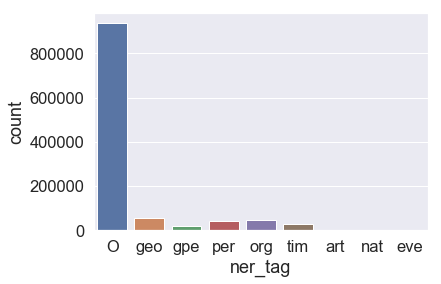

In [28]:
sns.countplot('ner_tag', data=tagged_texts_as_pd_f_add_f)
plt.show()

# Word distribution across sense numbers

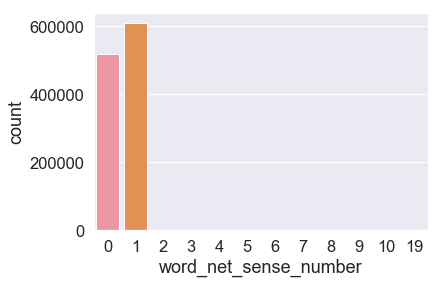

In [29]:
sns.countplot('word_net_sense_number', data=tagged_texts_as_pd_f_add_f)
plt.show()

# Word distribution across POS-tags

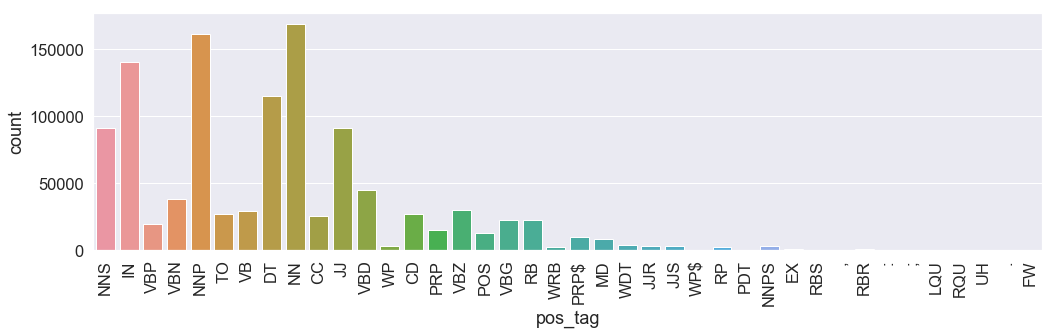

In [30]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('pos_tag', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Word distribution across semantic relation prepositions

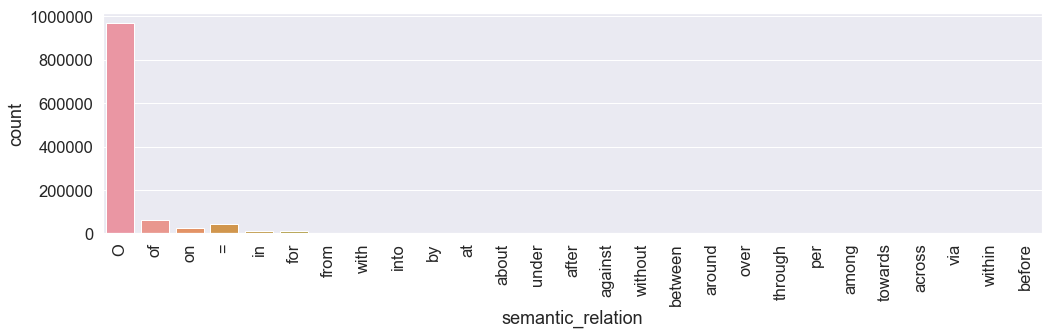

In [31]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('semantic_relation', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Word distribution across animacy-tags

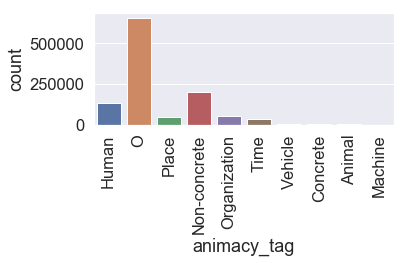

In [32]:
ax = sns.countplot('animacy_tag', data=tagged_texts_as_pd_f_add_f, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

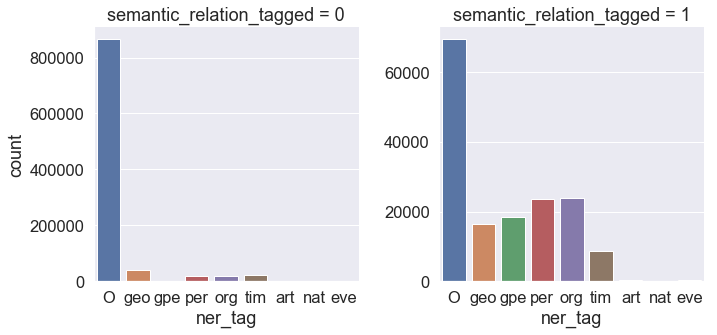

In [55]:
sns.catplot('ner_tag', col='semantic_relation_tagged', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

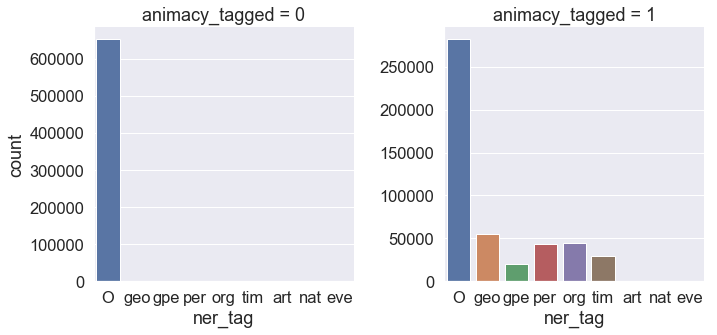

In [54]:
sns.catplot('ner_tag', col='animacy_tagged', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

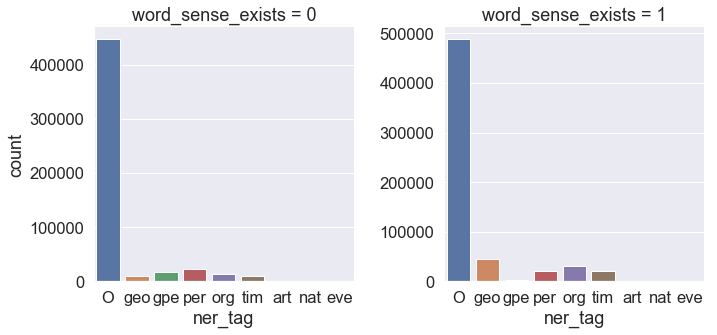

In [53]:
sns.catplot('ner_tag', col='word_sense_exists', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

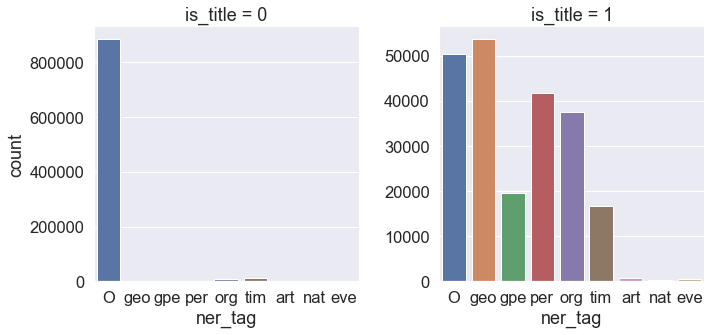

In [52]:
sns.catplot('ner_tag', col='is_title', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

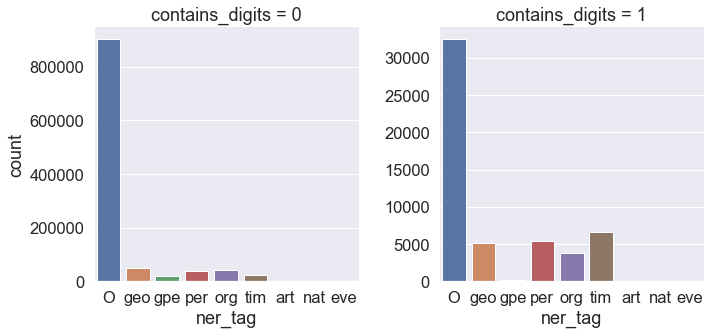

In [51]:
sns.catplot('ner_tag', col='contains_digits', data=tagged_texts_as_pd_f_add_f, kind="count", sharex=False, sharey=False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


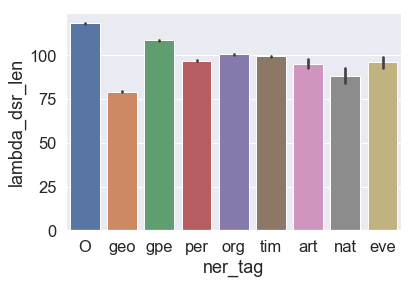

In [38]:
sns.barplot("ner_tag", "lambda_dsr_len", data=tagged_texts_as_pd_f_add_f)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


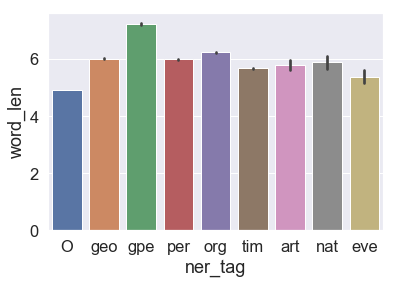

In [39]:
sns.barplot("ner_tag", "word_len", data=tagged_texts_as_pd_f_add_f)
plt.show()

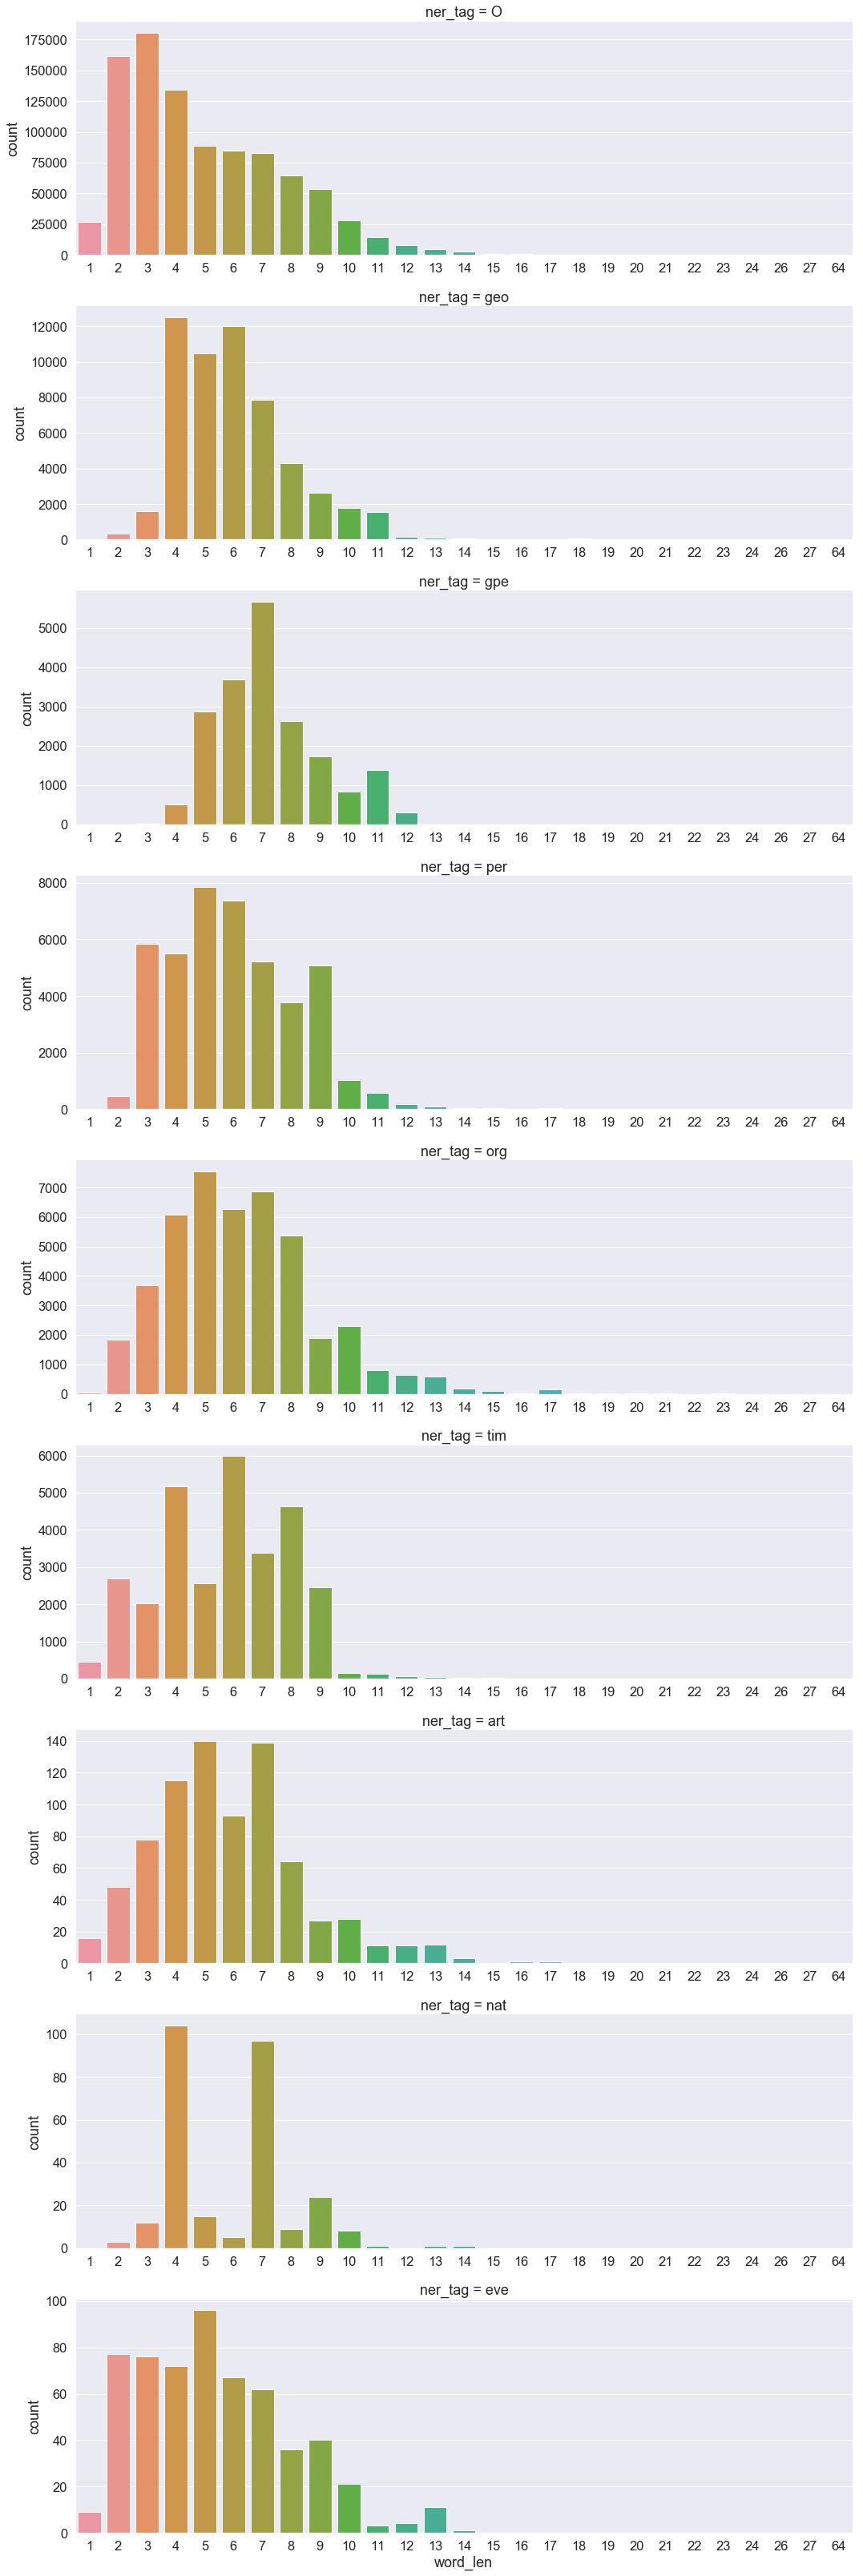

In [56]:
sns.catplot('word_len', col='ner_tag', data=tagged_texts_as_pd_f_add_f, kind="count", orient='h', col_wrap=1, sharex=False, sharey=False, aspect=3)
plt.show()